In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.mplot3d import Axes3D

In [3]:
flights = pd.read_csv("flights.csv", dtype=str)
airports = pd.read_csv("airports.csv", dtype=str)
airlines = pd.read_csv("airlines.csv", dtype=str)

In [4]:
print("Airlines Data:")
print(airlines.head())
print("\nAirports Data:")
print(airports.head())
print("\nFlights Data:")
print(flights.head())

Airlines Data:
  IATA_CODE                 AIRLINE
0        UA   United Air Lines Inc.
1        AA  American Airlines Inc.
2        US         US Airways Inc.
3        F9  Frontier Airlines Inc.
4        B6         JetBlue Airways

Airports Data:
  IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE   LONGITUDE  
0  40.65236   -75.44040  
1  32.41132   -99.68190  
2  35.04022  -106.60919  
3  45.44906   -98.42183  
4  31.53552   -84.19447  

Flights Data:
   YEAR MONTH DAY DAY_OF_WEEK AIRLINE FLIGHT_NUMBER TAIL_NUMBER  \
0  2015     1   1           4      AS   

In [5]:
def df_info(df):
    dat = df.__class__.__name__
    size = df.memory_usage(deep=True).sum() / (1024 * 1024)
    
    column_info = pd.DataFrame({
        'column': df.columns,
        'class': [str(df[col].dtype) for col in df.columns],
        'unique.values': [df[col].nunique() for col in df.columns],
        'missing.count': [df[col].isna().sum() for col in df.columns],
        'missing.pct': [round(df[col].isna().mean() * 100, 2) for col in df.columns]
    })
    
    result = {
        'data.frame': pd.DataFrame({'name': [dat], 'size': [size]}),
        'dimensions': pd.DataFrame({'rows': [df.shape[0]], 'columns': [df.shape[1]]}),
        'column.details': column_info
    }
    
    return result
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nCol = df.shape[1]
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 5 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        
        if np.issubdtype(columnDf.dtype, np.number):
            columnDf.hist()
        else:
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        
        plt.title(f'{df.columns[i]} (column {i})')
    plt.tight_layout()
    plt.show()

def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna(axis='columns')
    df = df.select_dtypes(include=[np.number])
    
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of numeric columns ({df.shape[1]}) is less than 2')
        return
    
    corr = df.corr()
    
    plt.figure(figsize=(graphWidth, graphWidth))
    corrMat = plt.matshow(corr.values, cmap='coolwarm')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number])
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]]
    
    columnNames = list(df)
    
    if len(columnNames) > 10:
        columnNames = columnNames[:10]
    
    df = df[columnNames]
    
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    
    corrs = df.corr().values
    
    for i, j in zip(*np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    
    plt.suptitle('Scatter and Density Plot', fontsize=15)
    plt.show()

In [6]:
flights_info = df_info(flights)
airports_info = df_info(airports)
airlines_info = df_info(airlines)

print(flights_info['data.frame'])
print(flights_info['dimensions'])
print(flights_info['column.details'])

print(airports_info['data.frame'])
print(airports_info['dimensions'])
print(airports_info['column.details'])

print(airlines_info['data.frame'])
print(airlines_info['dimensions'])
print(airlines_info['column.details'])


        name         size
0  DataFrame  8328.710768
      rows  columns
0  5819079       31
                 column   class  unique.values  missing.count  missing.pct
0                  YEAR  object              1              0         0.00
1                 MONTH  object             12              0         0.00
2                   DAY  object             31              0         0.00
3           DAY_OF_WEEK  object              7              0         0.00
4               AIRLINE  object             14              0         0.00
5         FLIGHT_NUMBER  object           6952              0         0.00
6           TAIL_NUMBER  object           4897          14721         0.25
7        ORIGIN_AIRPORT  object            628              0         0.00
8   DESTINATION_AIRPORT  object            629              0         0.00
9   SCHEDULED_DEPARTURE  object           1321              0         0.00
10       DEPARTURE_TIME  object           1440          86153         1.48
11      

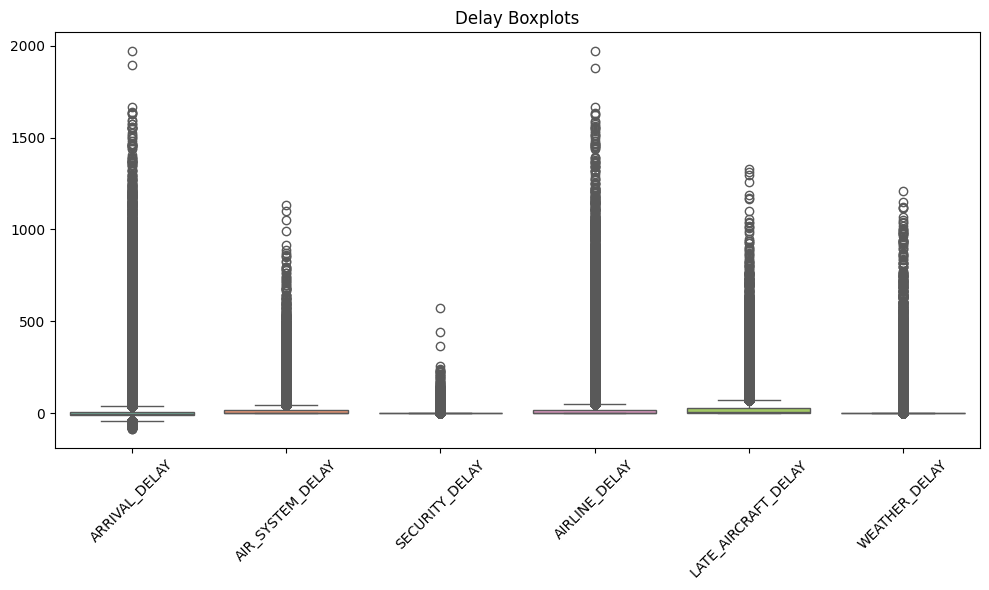

Data types after conversion:
ARRIVAL_DELAY          float64
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object

Sample data:
   ARRIVAL_DELAY  AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  \
0          -22.0               NaN             NaN            NaN   
1           -9.0               NaN             NaN            NaN   
2            5.0               NaN             NaN            NaN   
3           -9.0               NaN             NaN            NaN   
4          -21.0               NaN             NaN            NaN   

   LATE_AIRCRAFT_DELAY  WEATHER_DELAY  
0                  NaN            NaN  
1                  NaN            NaN  
2                  NaN            NaN  
3                  NaN            NaN  
4                  NaN            NaN  


In [9]:
keep = ["SCHEDULED_TIME", "ELAPSED_TIME", "AIR_TIME", "ARRIVAL_DELAY",
        "AIR_SYSTEM_DELAY", "SECURITY_DELAY", "AIRLINE_DELAY",
        "LATE_AIRCRAFT_DELAY", "WEATHER_DELAY"]
# Convert delay columns to numeric
delay_columns = keep[3:]  # Get only the delay columns
for col in delay_columns:
    flights[col] = pd.to_numeric(flights[col], errors='coerce')

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=flights[delay_columns], palette='Set2')
plt.title('Delay Boxplots')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()
print("Data types after conversion:")
print(flights[delay_columns].dtypes)
print("\nSample data:")
print(flights[delay_columns].head())

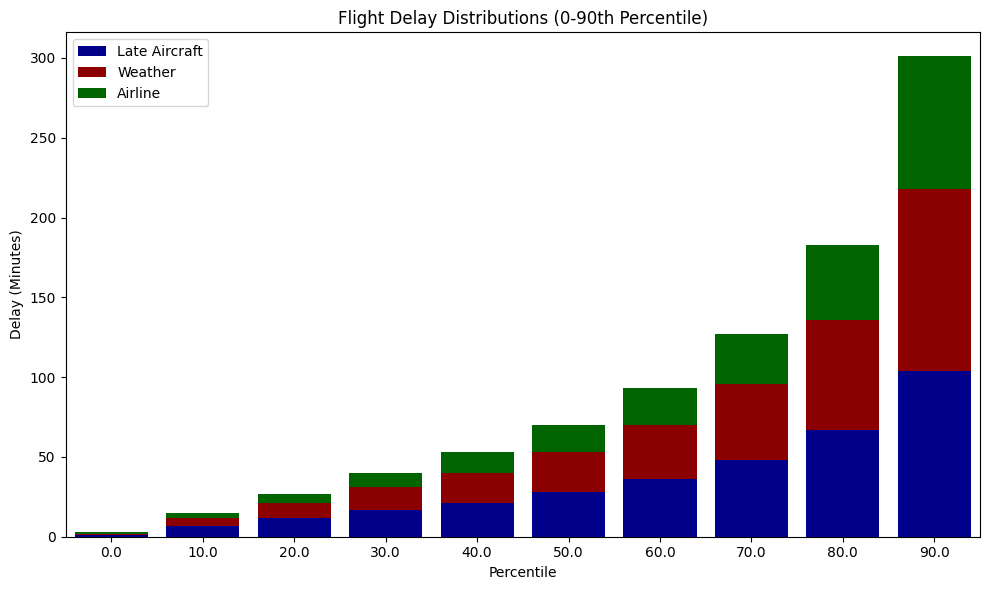

In [10]:
flights['LATE_AIRCRAFT_DELAY'] = pd.to_numeric(flights['LATE_AIRCRAFT_DELAY'], errors='coerce')
flights['WEATHER_DELAY'] = pd.to_numeric(flights['WEATHER_DELAY'], errors='coerce')
flights['AIRLINE_DELAY'] = pd.to_numeric(flights['AIRLINE_DELAY'], errors='coerce')

def p90(x):
    p = np.linspace(0, 0.9, 10)
    return np.percentile(x[x > 0], p * 100)

plt.figure(figsize=(10, 6))
late_aircraft_delay = p90(flights['LATE_AIRCRAFT_DELAY'].dropna())
weather_delay = p90(flights['WEATHER_DELAY'].dropna())
airline_delay = p90(flights['AIRLINE_DELAY'].dropna())

plt.bar(np.arange(len(late_aircraft_delay)), late_aircraft_delay, color='darkblue', label="Late Aircraft")
plt.bar(np.arange(len(weather_delay)), weather_delay, color='darkred', bottom=late_aircraft_delay, label="Weather")
plt.bar(np.arange(len(airline_delay)), airline_delay, color='darkgreen', bottom=late_aircraft_delay + weather_delay, label="Airline")

plt.title("Flight Delay Distributions (0-90th Percentile)")
plt.xlabel("Percentile")
plt.ylabel("Delay (Minutes)")
plt.xticks(np.arange(len(late_aircraft_delay)), np.round(np.linspace(0, 90, 10), 1))
plt.xlim(-0.5, len(late_aircraft_delay) - 0.5)
plt.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()

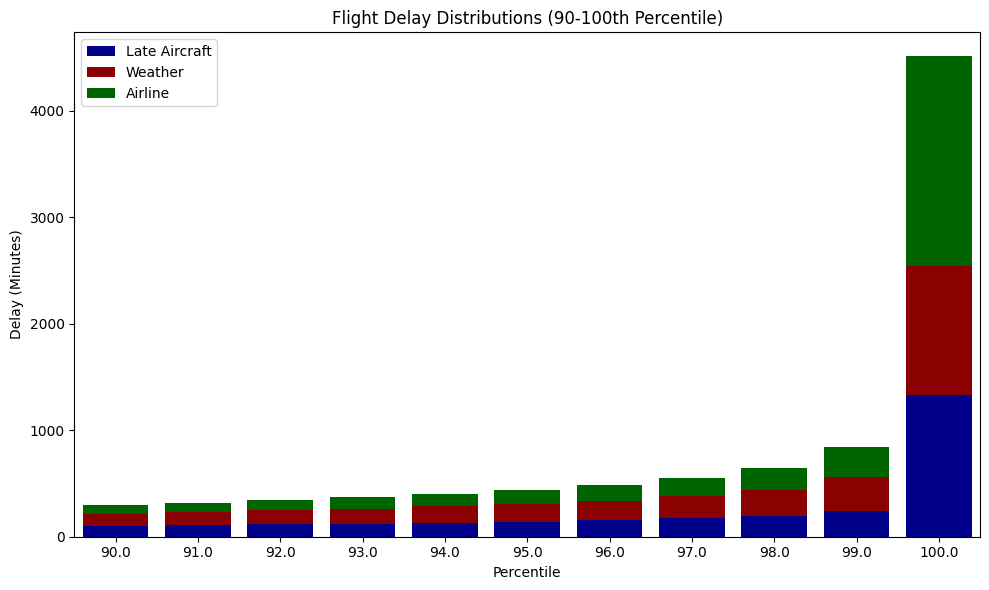

In [11]:
flights['LATE_AIRCRAFT_DELAY'] = pd.to_numeric(flights['LATE_AIRCRAFT_DELAY'], errors='coerce')
flights['WEATHER_DELAY'] = pd.to_numeric(flights['WEATHER_DELAY'], errors='coerce')
flights['AIRLINE_DELAY'] = pd.to_numeric(flights['AIRLINE_DELAY'], errors='coerce')

def right_tail(x):
    p = np.linspace(0.9, 1, 11)
    return np.percentile(x[x > 0], p * 100)

plt.figure(figsize=(10, 6))

late_aircraft_delay_right = right_tail(flights['LATE_AIRCRAFT_DELAY'].dropna())
weather_delay_right = right_tail(flights['WEATHER_DELAY'].dropna())
airline_delay_right = right_tail(flights['AIRLINE_DELAY'].dropna())

plt.bar(np.arange(len(late_aircraft_delay_right)), late_aircraft_delay_right, color='darkblue', label="Late Aircraft")
plt.bar(np.arange(len(weather_delay_right)), weather_delay_right, color='darkred', bottom=late_aircraft_delay_right, label="Weather")
plt.bar(np.arange(len(airline_delay_right)), airline_delay_right, color='darkgreen', bottom=late_aircraft_delay_right + weather_delay_right, label="Airline")

plt.title("Flight Delay Distributions (90-100th Percentile)")
plt.xlabel("Percentile")
plt.ylabel("Delay (Minutes)")
plt.xticks(np.arange(len(late_aircraft_delay_right)), np.round(np.linspace(90, 100, 11), 1))
plt.xlim(-0.5, len(late_aircraft_delay_right) - 0.5)
plt.legend(loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()

In [12]:
nRowsRead = 1000
df1 = pd.read_csv('airlines.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'airlines.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 14 rows and 2 columns


In [13]:
df1.head(5)

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


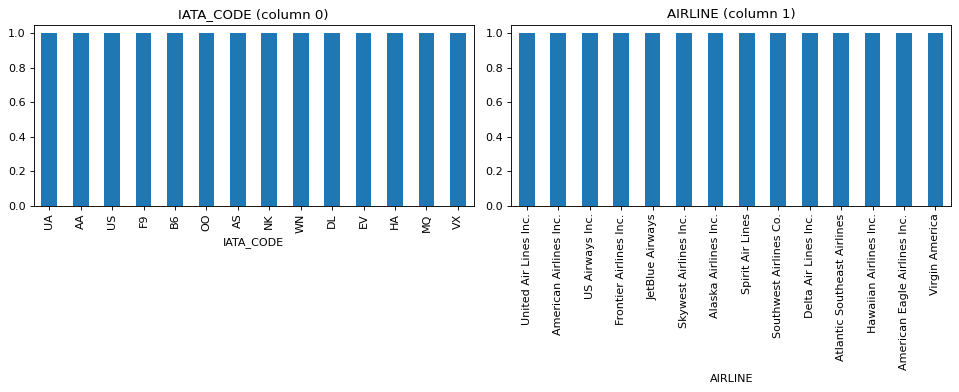

In [14]:
plotPerColumnDistribution(df1, 10, 5)

In [15]:
nRowsRead = 1000 # specify 'None' if want to read whole file
#airports.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('airports.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'airports.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 322 rows and 7 columns


In [16]:
df2.head(5)

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [17]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# flights.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('flights.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'flights.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 31 columns


In [18]:
df3.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


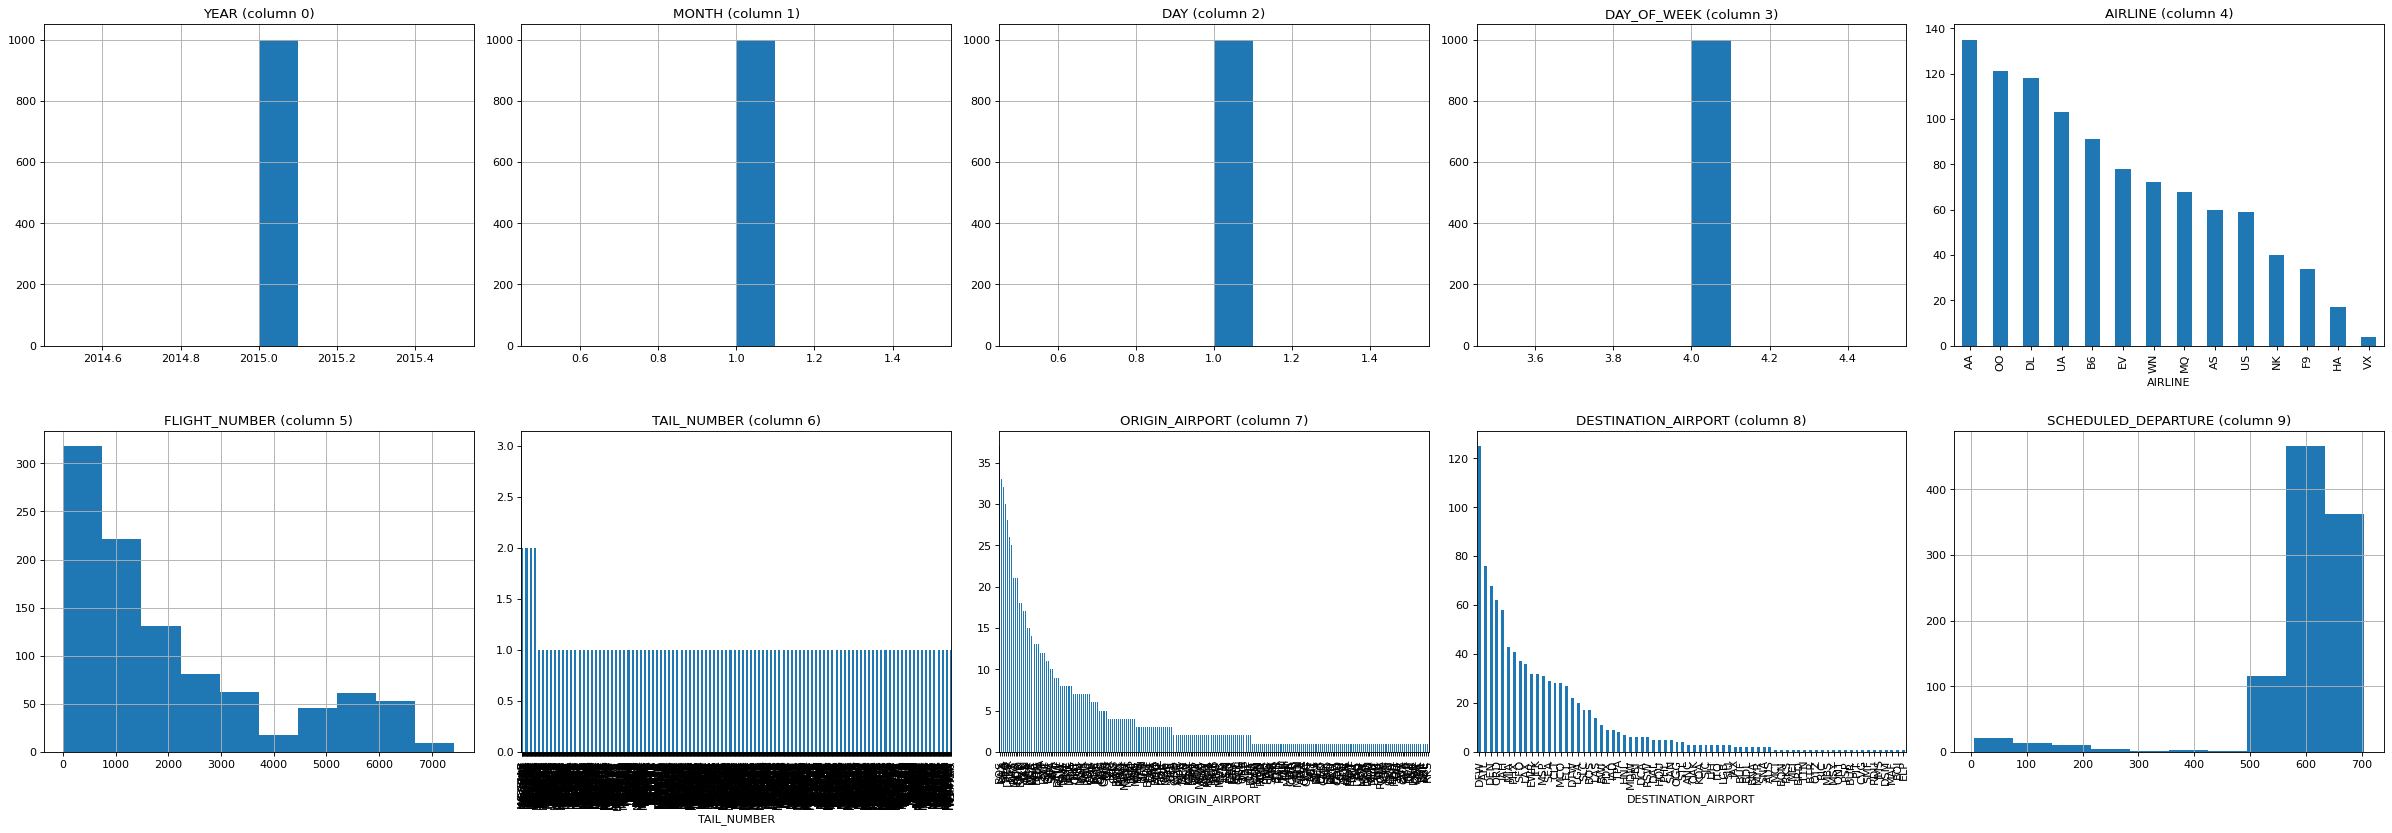

In [19]:
plotPerColumnDistribution(df3, 10, 5)

<Figure size 800x800 with 0 Axes>

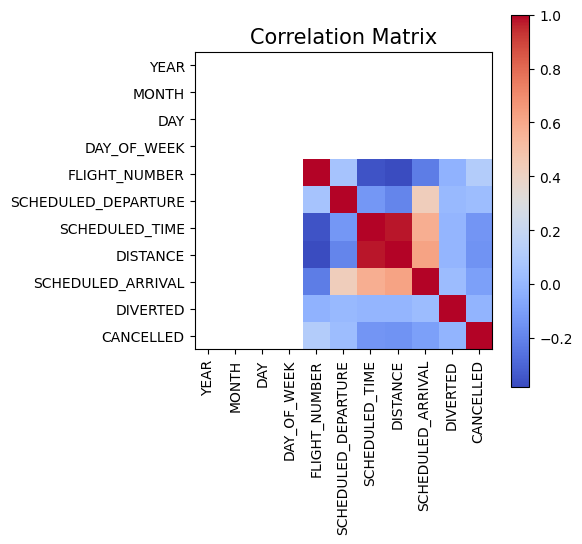

In [20]:
plotCorrelationMatrix(df3, 8)

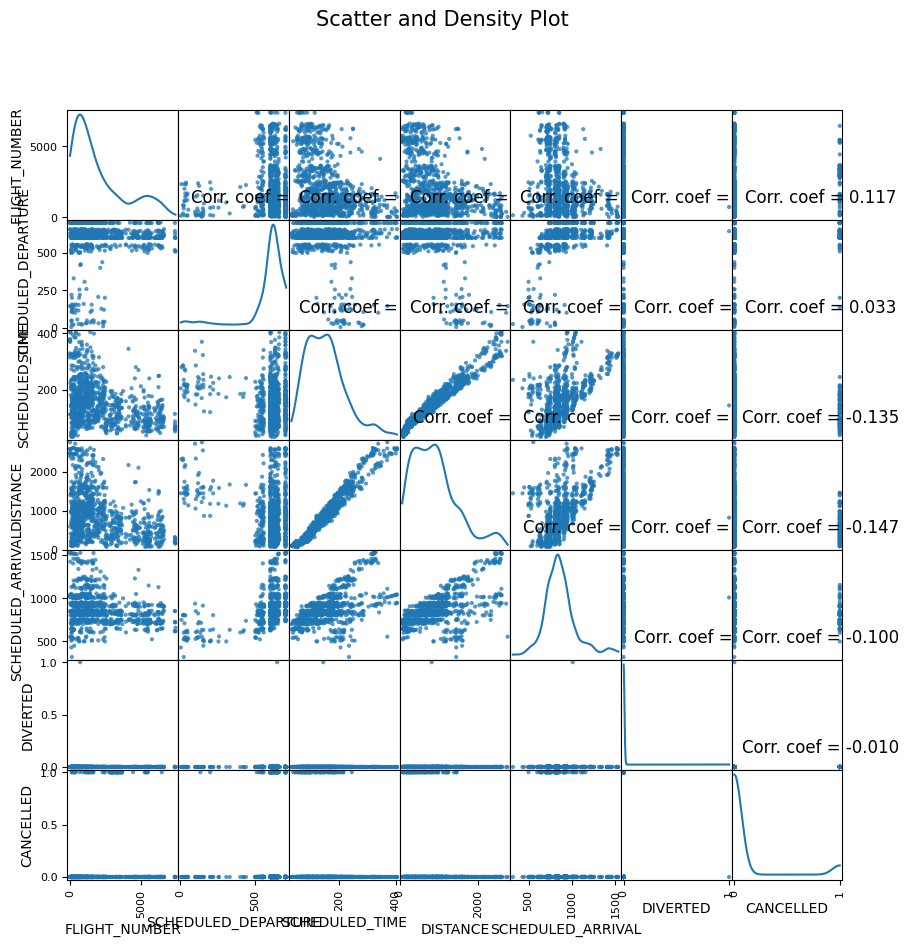

In [21]:
plotScatterMatrix(df3, 10, 12)

Table of Mean Arrival Delay and Frequency:
                     AirlineName AirlineCode  MeanArrivalDelay
1           Alaska Airlines Inc.          AS         -0.976563
3           Delta Air Lines Inc.          DL          0.186754
6         Hawaiian Airlines Inc.          HA          2.023093
0         American Airlines Inc.          AA          3.451372
11               US Airways Inc.          US          3.706209
13        Southwest Airlines Co.          WN          4.374964
12                Virgin America          VX          4.737706
10         United Air Lines Inc.          UA          5.431594
9          Skywest Airlines Inc.          OO          5.845652
7   American Eagle Airlines Inc.          MQ          6.457873
4    Atlantic Southeast Airlines          EV          6.585379
2                JetBlue Airways          B6          6.677861
5         Frontier Airlines Inc.          F9         12.504706
8               Spirit Air Lines          NK         14.471800

Frequency o

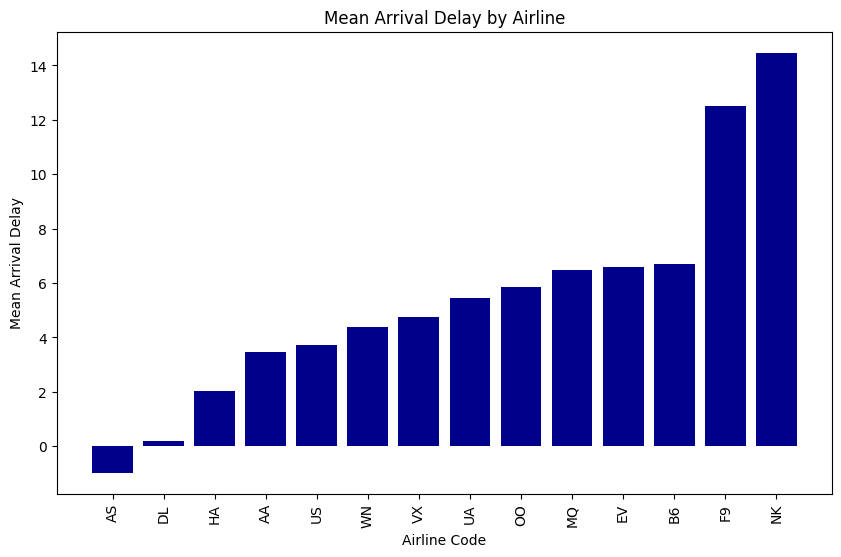

In [22]:
flights['ARRIVAL_DELAY'] = pd.to_numeric(flights['ARRIVAL_DELAY'], errors='coerce')
airline_avg_delay = flights.groupby('AIRLINE')['ARRIVAL_DELAY'].mean().reset_index()
airline_avg_delay = airline_avg_delay.merge(airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')
airline_avg_delay.rename(columns={'AIRLINE_x': 'AirlineCode', 'AIRLINE_y': 'AirlineName'}, inplace=True)
airline_avg_delay = airline_avg_delay.sort_values(by='ARRIVAL_DELAY')
airline_avg_delay = airline_avg_delay[['AirlineName', 'AirlineCode', 'ARRIVAL_DELAY']]
airline_avg_delay.columns = ['AirlineName', 'AirlineCode', 'MeanArrivalDelay']
delay_frequency = airline_avg_delay['MeanArrivalDelay'].value_counts().reset_index()
delay_frequency.columns = ['MeanArrivalDelay', 'Frequency']
print("Table of Mean Arrival Delay and Frequency:")
print(airline_avg_delay)
print("\nFrequency of Mean Arrival Delays:")
print(delay_frequency)
plt.figure(figsize=(10, 6))
plt.bar(airline_avg_delay['AirlineCode'], airline_avg_delay['MeanArrivalDelay'], color='darkblue')
plt.title('Mean Arrival Delay by Airline')
plt.xlabel('Airline Code')
plt.ylabel('Mean Arrival Delay')
plt.xticks(rotation=90)
plt.show()

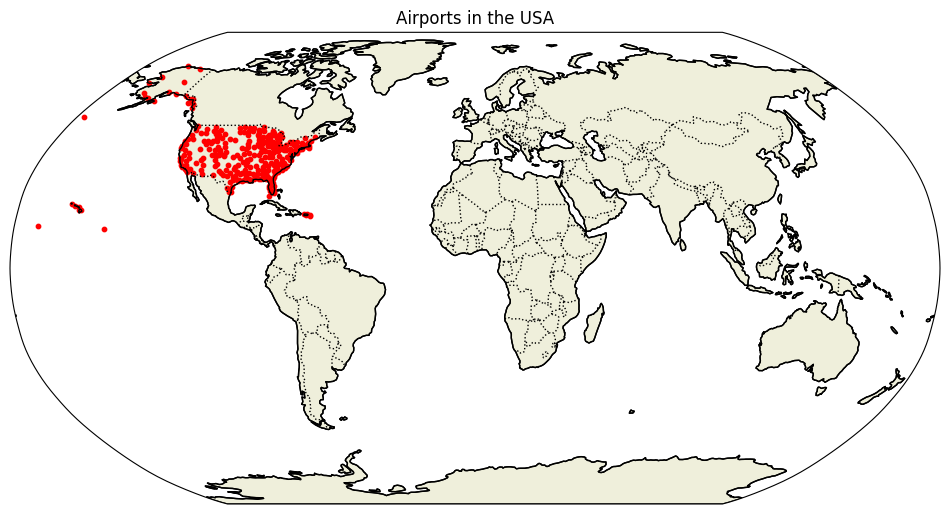

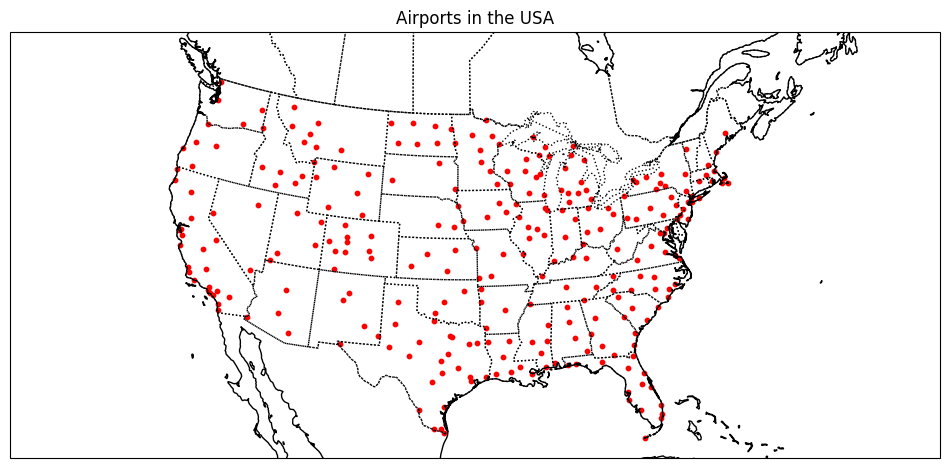

In [23]:
airports['LONGITUDE'] = pd.to_numeric(airports['LONGITUDE'], errors='coerce')
airports['LATITUDE'] = pd.to_numeric(airports['LATITUDE'], errors='coerce')
airports = airports.dropna(subset=['LONGITUDE', 'LATITUDE'])
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.scatter(airports['LONGITUDE'], airports['LATITUDE'], color='red', marker='o', s=10, transform=ccrs.PlateCarree())
plt.title("Airports in the USA")
plt.show()
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.LambertConformal())
ax.set_extent([-130, -60, 20, 50])
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.scatter(airports['LONGITUDE'], airports['LATITUDE'], color='red', marker='o', s=10, transform=ccrs.PlateCarree())
plt.title("Airports in the USA")
plt.show()

In [30]:
flights_sample = flights.sample(n=10000, random_state=42)

flights_sample['DEPARTURE_DELAY'] = pd.to_numeric(flights_sample['DEPARTURE_DELAY'], errors='coerce')
flights_sample['ARRIVAL_DELAY'] = pd.to_numeric(flights_sample['ARRIVAL_DELAY'], errors='coerce')

flights_sample['flight_delayed'] = (flights_sample['DEPARTURE_DELAY'] > 15) | (flights_sample['ARRIVAL_DELAY'] > 15)

feature_cols = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 
                'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                'SCHEDULED_DEPARTURE', 'DISTANCE', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME']

available_cols = [col for col in feature_cols if col in flights_sample.columns]
X = flights_sample[available_cols].copy()

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna('Unknown')
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = flights_sample['flight_delayed'].fillna(False)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.7715
